In [ ]:
import cv2
import collections
import time 
from tqdm import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import copy
import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import pydicom
from PIL import Image
import time
import sys
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import albumentations as albu
from albumentations import Compose,Resize,OneOf,RandomBrightness,RandomContrast,Normalize,HorizontalFlip,Blur,ElasticTransform,GridDistortion,OpticalDistortion,GaussNoise 
from albumentations.pytorch import ToTensor
import segmentation_models_pytorch as smp
import os
import random

import re
def export_num(string):
    find_num = re.compile('[0-9.]+')
    number = find_num.findall(string[-10:-4])
    return int(number[0])

seed = 1015
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


os.environ["CUDA_VISIBLE_DEVICES"]="1"
PATH = "../../../cpt_data/ct_new/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
dir_path = "../../data/random_shift/img/"
target = pd.read_csv('../../data/random_shift/random_shift_target.csv')
target["height"] = 512
target["width"] = target.end_x - target.start_x
target["img_path"] = target["person_mul_index"] + '.png'
target
coco_bbox = pd.DataFrame(target.img_path)
coco_bbox['left'] = target.loc[:, 'start_x'].values
coco_bbox['top'] = [0 for i in range(len(target))]
coco_bbox['width'] = target.loc[:, 'width'].values
coco_bbox['height'] = target.loc[:, 'height'].values                             
#coco_bbox.index = coco_bbox.index + 1
coco_bbox

,img_path,left,top,width,height
0,00003552_252.png,171,0,86,512
1,00003552_253.png,397,0,86,512
2,00003552_254.png,184,0,86,512
3,00003552_255.png,284,0,86,512
4,00003552_256.png,188,0,86,512
...,...,...,...,...,...
535,00004237_256.png,295,0,80,512
536,00004237_257.png,275,0,80,512
537,00004237_258.png,329,0,80,512
538,00004237_259.png,195,0,80,512


In [3]:
class SAGITALL_Dataset(torch.utils.data.Dataset):
    def __init__(self, meta_data, 
                 transform=None,
                 preprocessing=None,
                 classes=None, 
                 augmentation=None, 
                ):
        self.meta_data = meta_data.reset_index()
        self.transforms = transform
        self.classes = classes
        self.preprocessing = preprocessing
        self.augmentation = augmentation
        self.imgsize = 512
        self.resize =  Compose([
                                  albu.Resize(height = self.imgsize, width = self.imgsize),
                               ])
        self.to_tensor = Compose([
                                  albu.Lambda(image=  to_tensor, mask=to_tensor),
                               ])
        
        
    def __getitem__(self,index):
        img_path = dir_path + self.meta_data.loc[index, 'img_path']
        left = self.meta_data.loc[index, 'left']
        width = self.meta_data.loc[index, 'width']
        
        image = np.array(Image.open(img_path))
        target_mask = np.zeros((512,512))
        target_mask[:, left:left+width] = 1
        # 읽어오기 -> numpy변환 -> 가운데만 선택
        
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=target_mask)
            image, target_mask = sample['image'], sample['mask']
            
            
        image = image[...,np.newaxis]
        target_mask = target_mask[...,np.newaxis]
            
            
        sample = self.to_tensor(image=image, mask=target_mask)
        image, target_mask = sample['image'], sample['mask']
        
        
        
        return image/255, target_mask
        #return torch.tensor(image, device = device), torch.tensor(target_mask, device = device)
    
    def __len__(self):
        return len(self.meta_data)
    
def get_training_augmentation():
    transform = [
        albu.Transpose(p=0.5),
        albu.RandomRotate90(2, p = 0.5),
        albu.Rotate(p=1),
        #albu.GridDistortion(p = 0.2), # 2배
        #albu.GridDropout(p=0.5, ratio = 0.3),
        ]
    return albu.Compose(transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image = preprocessing_fn),
    ]
    return albu.Compose(_transform)

CLASSES = 1

/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2247: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


(1, 512, 512)
(1, 512, 512)


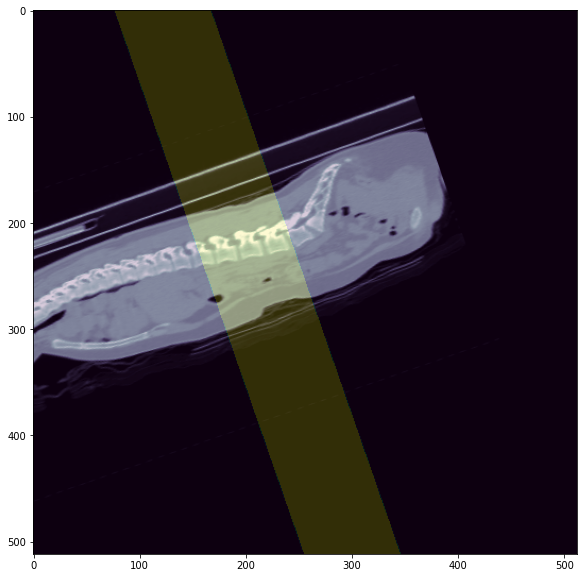

In [4]:
CLASSES = 1
img_id = 0
dataset = SAGITALL_Dataset(coco_bbox, \
                           augmentation = get_training_augmentation(),
                           classes=CLASSES)
image, target = dataset[img_id]
print(image.shape)
print(target.shape)


plt.figure(figsize=(10,10))
img, mask = dataset[img_id]
plt.imshow(img[0,:,:], cmap='bone')
plt.imshow(mask[0,:,:], alpha = 0.2)
plt.show()

In [5]:
train_df = coco_bbox.loc[:400,:]
valid_df = coco_bbox.loc[400:,:]

In [6]:
import torch

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    def step(self, closure=None):
        raise NotImplementedError("SAM doesn't work like the other optimizers, you should first call `first_step` and the `second_step`; see the documentation for more info.")

    def _grad_norm(self):
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 0
seed_everything(SEED)


class DiceScore(smp.utils.base.Metric):
    __name__ = 'dice_score'

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        #self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = smp.utils.functional._threshold(y_pr, threshold=self.threshold)
        y_pr, y_gt = smp.utils.functional._take_channels(y_pr, y_gt, ignore_channels=self.ignore_channels)
        tp = torch.sum(y_gt * y_pr)
        total = torch.sum(y_gt) + torch.sum(y_pr)
        score = (tp + self.eps) * 2 / (total + self.eps)
        return score


class DiceBCELoss(smp.utils.base.Loss):
    __name__ = 'dice_bce_loss'
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.diceloss = smp.utils.losses.DiceLoss()
        self.bceloss  = torch.nn.BCELoss()
        self.bceloss.__name__ = 'bce_loss'
    def forward(self, y_pr, y_gt):
        return 0.4 * self.diceloss.forward(y_pr, y_gt) + 0.6 * self.bceloss.forward(y_pr, y_gt)



class SamTrainEpoch(smp.utils.train.TrainEpoch):
    def __init__(self, model, loss, metrics, optimizer, device='cuda', verbose=True):
        super().__init__(
            model = model,
            loss = loss,
            metrics = metrics,
            optimizer = optimizer,
            device = device,
            verbose = verbose
        )

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)

        #
        loss = self.loss(prediction, y)
        loss.backward()
        optimizer.first_step(zero_grad=True)

        self.loss(self.model.forward(x), y).backward()
        optimizer.second_step(zero_grad=True)

        return loss, prediction

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = smp.utils.meter.AverageValueMeter()
        metrics_meters = {metric.__name__: smp.utils.meter.AverageValueMeter() for metric in self.metrics}

        with tqdm(dataloader, desc=self.stage_name, file=sys.stdout, disable=not (self.verbose)) as iterator:
            
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)
                
                '''
                new_logs = {}
                for key in logs.keys():
                    new_logs['train_'+key] = logs[key]
                wandb.log(new_logs)
                '''

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)
        return logs

In [7]:
coco_bbox

,img_path,left,top,width,height
0,00003552_252.png,171,0,86,512
1,00003552_253.png,397,0,86,512
2,00003552_254.png,184,0,86,512
3,00003552_255.png,284,0,86,512
4,00003552_256.png,188,0,86,512
...,...,...,...,...,...
535,00004237_256.png,295,0,80,512
536,00004237_257.png,275,0,80,512
537,00004237_258.png,329,0,80,512
538,00004237_259.png,195,0,80,512


1

Epoch: 0
train:   0%|          | 0/54 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2247: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


valid: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s, dice_bce_loss - 0.5908, dice_score - 6.787e-13]


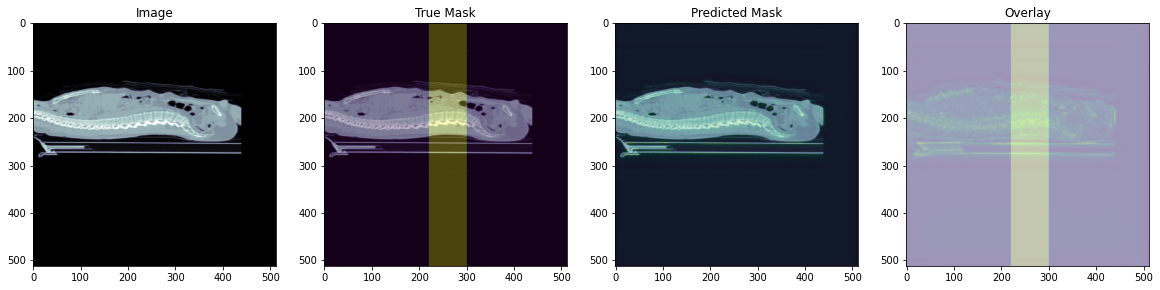


Epoch: 1
valid: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s, dice_bce_loss - 0.5977, dice_score - 6.787e-13]


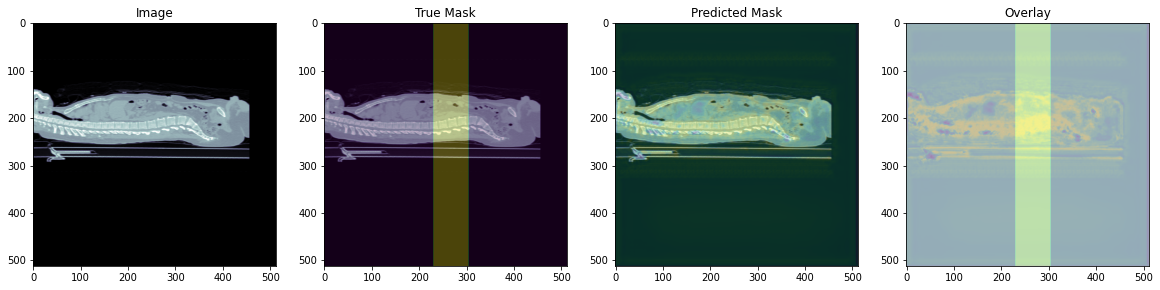


Epoch: 2
valid: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s, dice_bce_loss - 0.5551, dice_score - 0.4638]


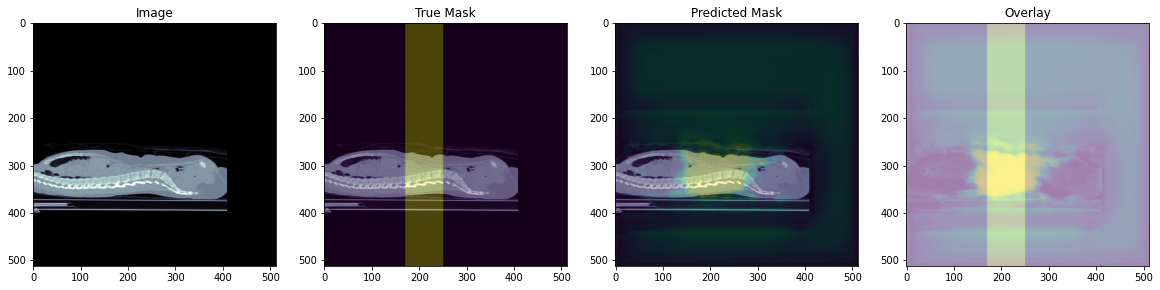


Epoch: 3
valid: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s, dice_bce_loss - 0.4029, dice_score - 0.5819]


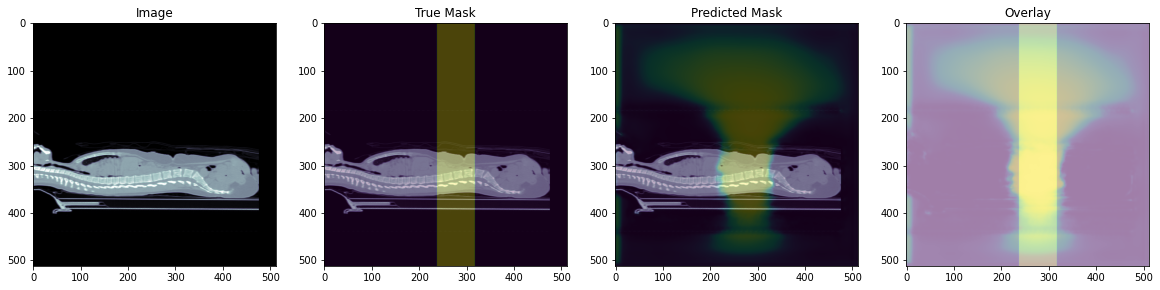


Epoch: 4
valid: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s, dice_bce_loss - 0.2308, dice_score - 0.7582]


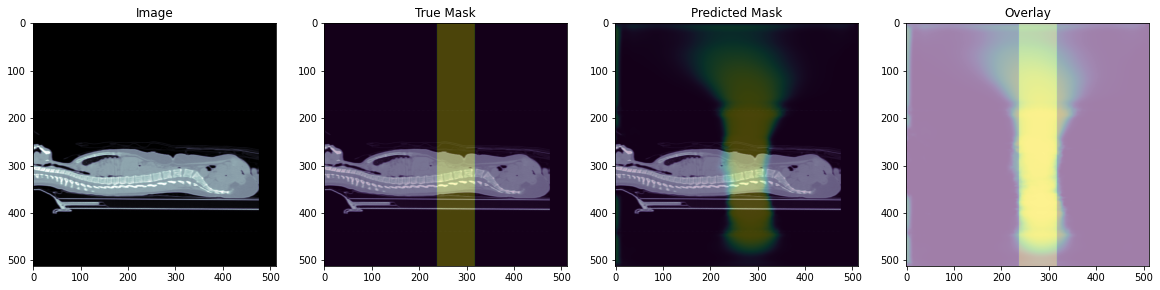


Epoch: 5
valid: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s, dice_bce_loss - 0.1822, dice_score - 0.8026]


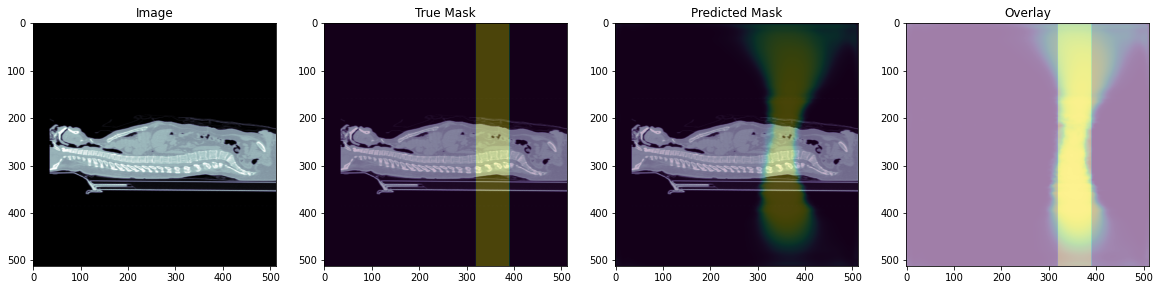


Epoch: 6
valid: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s, dice_bce_loss - 0.1205, dice_score - 0.8864]


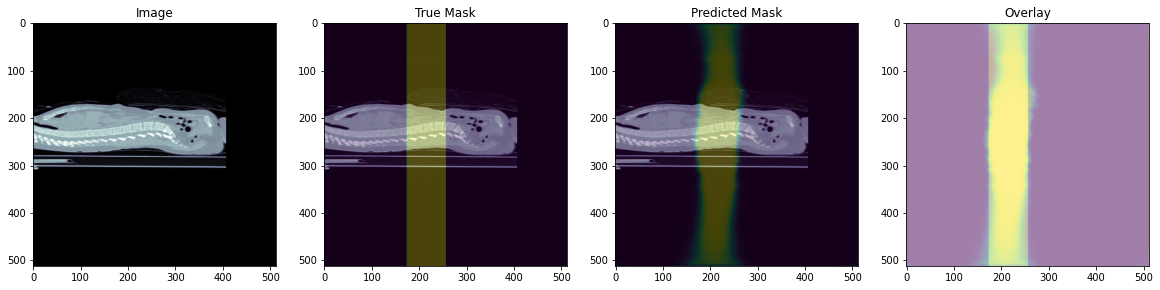


Epoch: 7
valid: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s, dice_bce_loss - 0.1169, dice_score - 0.8756]


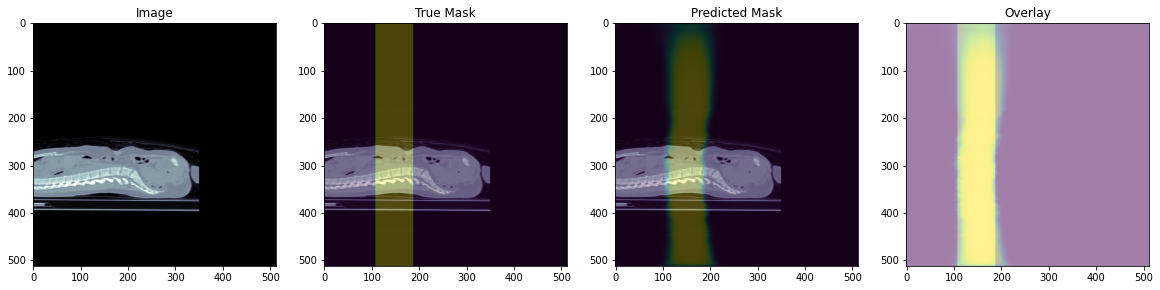


Epoch: 8
valid: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s, dice_bce_loss - 0.1097, dice_score - 0.8848]


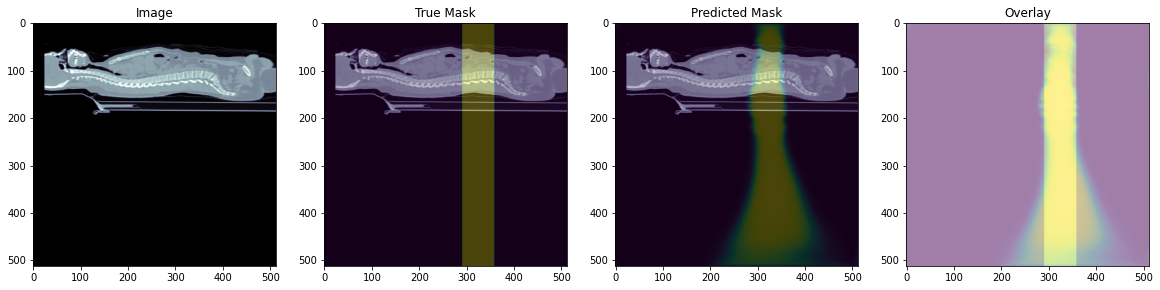


Epoch: 9
valid: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s, dice_bce_loss - 0.09995, dice_score - 0.8995]


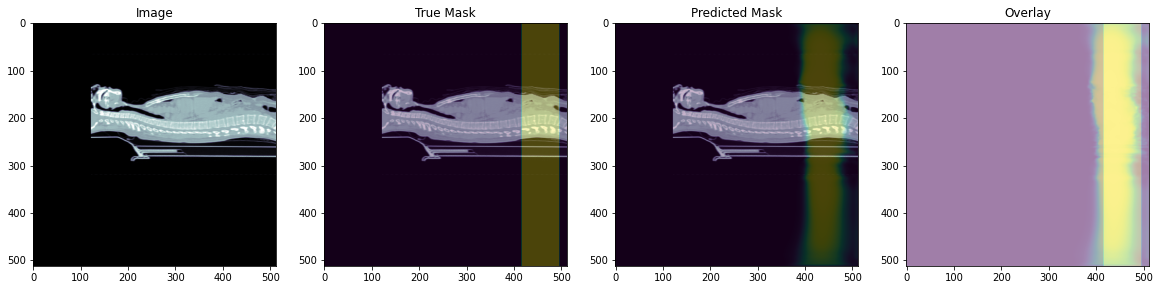

In [8]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=False)

target_fold_index = 1
for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(coco_bbox.index),1):
    print(fold_index)
    if fold_index == target_fold_index:
        train_names, test_names = coco_bbox.loc[trn_idx,:], coco_bbox.loc[val_idx,:]

        ENCODER = 'efficientnet-b7'
        ENCODER_WEIGHTS = 'imagenet'
        DEVICE = 'cuda'
        ACTIVATION = 'sigmoid'

        model = smp.Unet(
                    encoder_name=ENCODER, 
                    encoder_weights=ENCODER_WEIGHTS, 
                    in_channels = 1,
                    classes=1, 
                    activation = ACTIVATION
                )
        #loss = smp.utils.losses.DiceLoss()
        loss = DiceBCELoss()
        # 마찬가지로 mae_over_fscore의 pytorch metric version입니다.
        metrics = [DiceScore(threshold=0.5)]
        #base_optimizer = Ralamb(model.parameters(), weight_decay=0.01)
        #optimizer = Lookahead(base_optimizer)
        base_optimizer = torch.optim.SGD
        optimizer = SAM(model.parameters(),
                        base_optimizer,
                        lr=0.1,
                        momentum=0.9)

        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                             10,
                                                             2,
                                                             eta_min=1e-6) # 1e-6

        train_epoch = SamTrainEpoch(
            model, 
            loss=loss, 
            metrics=metrics, 
            optimizer=optimizer,
            device=DEVICE,
            verbose=True,
        )

        valid_epoch = smp.utils.train.ValidEpoch(
            model, 
            loss=loss, 
            metrics=metrics, 
            device=DEVICE,
            verbose=True,
        )

        BATCH_SIZE = 8
        train_dataset = SAGITALL_Dataset(train_names, augmentation = get_training_augmentation(),  classes=1)
        valid_dataset = SAGITALL_Dataset(test_names, classes=1)
        train_loader = DataLoader(train_dataset,  batch_size=BATCH_SIZE, shuffle=True, num_workers=4, persistent_workers = True)
        valid_loader = DataLoader(valid_dataset,  batch_size=8, shuffle=False, num_workers=2)

        # 한 폴드당 150 Epoch 수행
        NUM_EPOCH = 10
        min_score = np.Inf

        #MODEL = train_name
        best_val_loss = 100
        for i in range(0, NUM_EPOCH):
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader)
            valid_logs = valid_epoch.run(valid_loader)

            path = '../models/unet_effb7/'
            MODEL = 'unet_effb7'
            scheduler.step()
            valid_loss = valid_logs['dice_bce_loss']
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                torch.save(model, f'{path}{fold_index}_{MODEL}_{loss.__name__}_{valid_loss:2.4f}_epoch_{i}.pth')

            with torch.no_grad():
                sample_img, sample_mask = valid_dataset[np.random.randint(valid_dataset.__len__())]
                sample_tensor = torch.cuda.FloatTensor(sample_img[np.newaxis,...])
                sample_pred   = model.predict(sample_tensor).cpu().numpy()[0]

                plt.figure(figsize=(20,5))
                #img, mask = dataset[img_id]
                plt.subplot(1,4,1)
                plt.imshow(sample_img[0,:,:], cmap='bone') # 원본 # permute는 축 변경
                plt.gca().set_title("Image")
                plt.subplot(1,4,2)
                plt.imshow(sample_img[0,:,:], cmap='bone') # 원본 # permute는 축 변경
                plt.imshow(sample_mask[0,:,:], alpha=0.3) # 레이블
                plt.gca().set_title("True Mask")
                plt.subplot(1,4,3)
                plt.imshow(sample_img[0,:,:], cmap='bone') # 원본 # permute는 축 변경
                plt.imshow(sample_pred[0,:,:], alpha=0.3) # 레이블
                plt.gca().set_title("Predicted Mask")
                plt.subplot(1,4,4)
                plt.imshow(sample_mask[0,:,:], alpha=0.3) # 레이블
                plt.imshow(sample_pred[0,:,:], alpha=0.3) # 레이블
                plt.gca().set_title("Overlay")
                plt.show()
                
        target_fold_index += 1
        break


Epoch: 10
valid: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s, dice_bce_loss - 0.1128, dice_score - 0.8765]


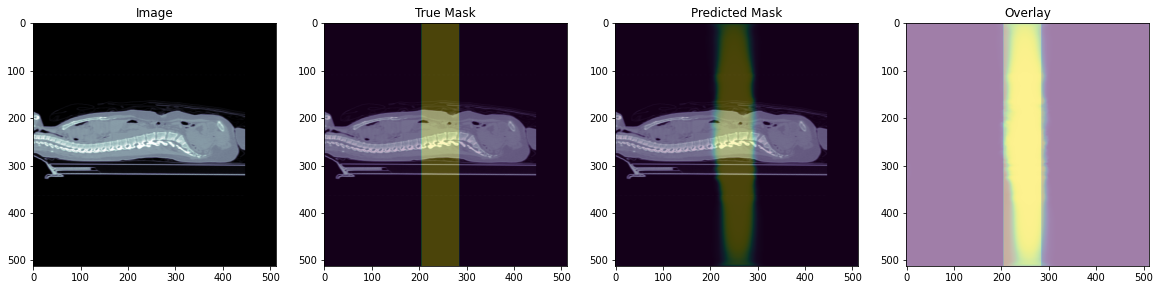


Epoch: 11
valid: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s, dice_bce_loss - 0.1021, dice_score - 0.8927]


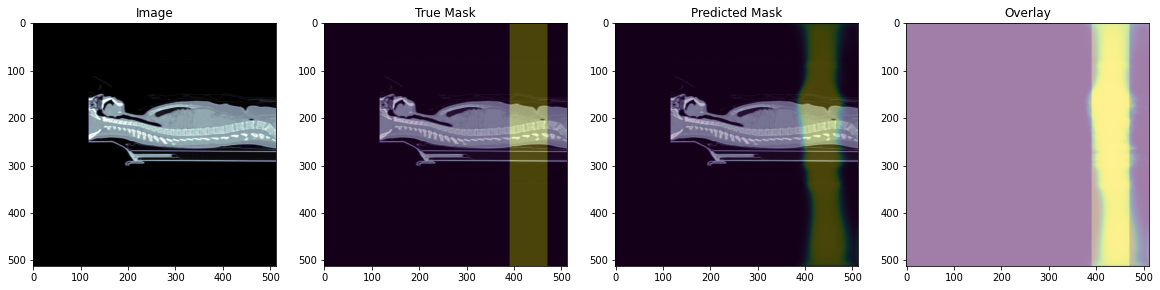


Epoch: 12
valid: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s, dice_bce_loss - 0.08506, dice_score - 0.9135]


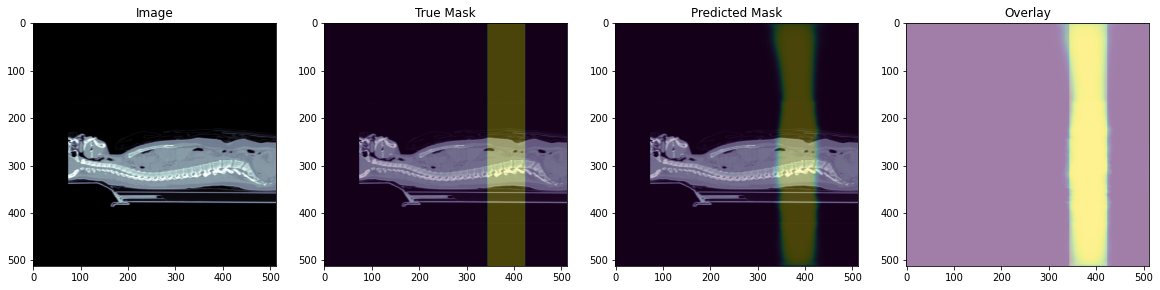


Epoch: 13
valid: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s, dice_bce_loss - 0.08769, dice_score - 0.9087]


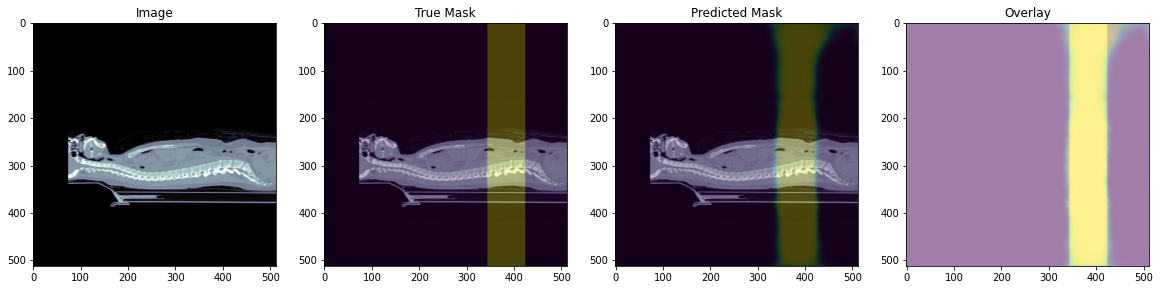


Epoch: 14
valid: 100%|██████████| 14/14 [00:03<00:00,  4.03it/s, dice_bce_loss - 0.0831, dice_score - 0.9149] 


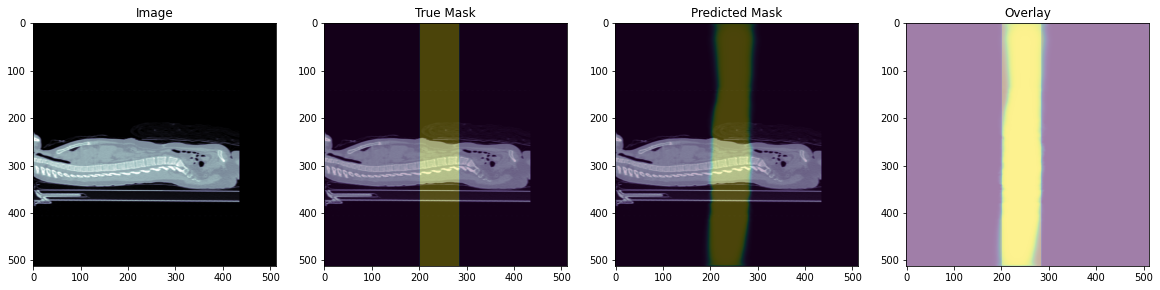


Epoch: 15
valid: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s, dice_bce_loss - 0.07747, dice_score - 0.919] 


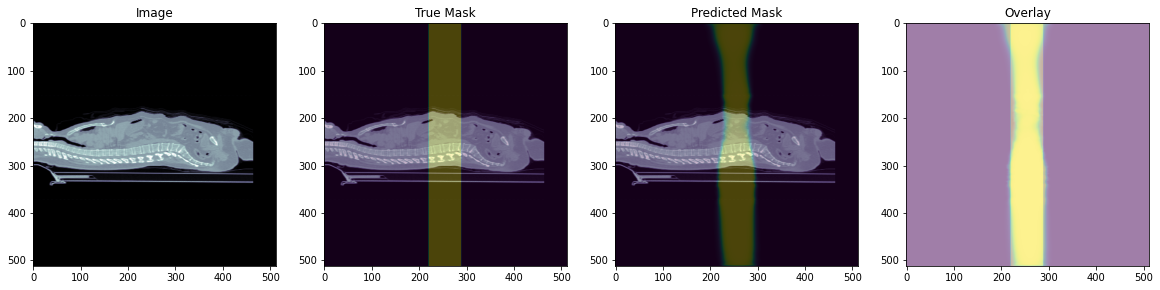


Epoch: 16
valid: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s, dice_bce_loss - 0.07413, dice_score - 0.9245]


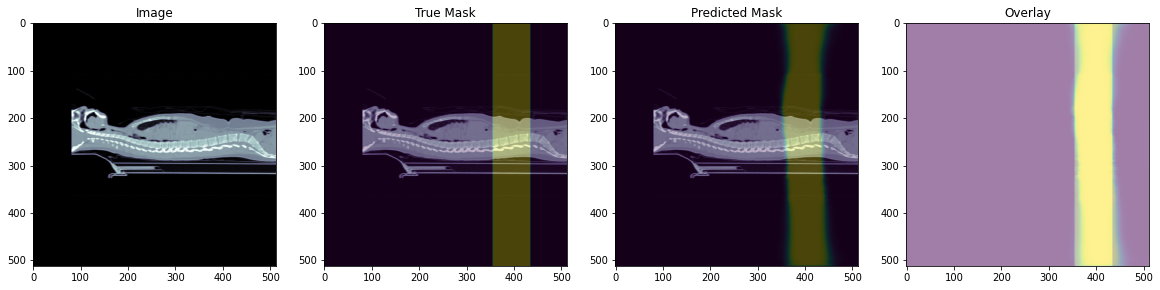


Epoch: 17
valid: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s, dice_bce_loss - 0.07421, dice_score - 0.9251]


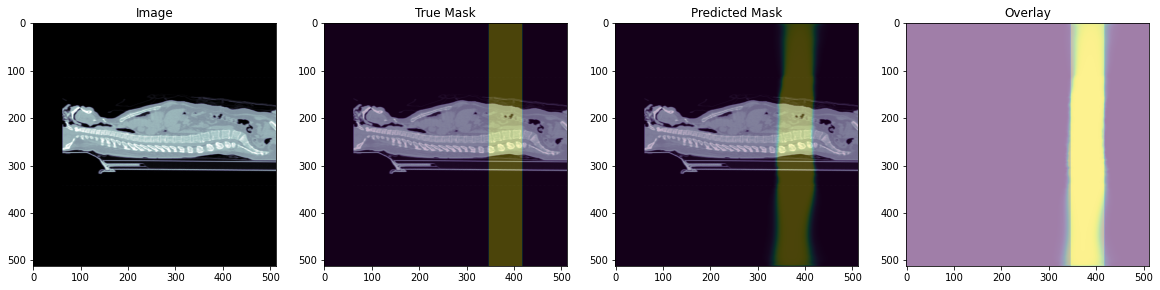


Epoch: 18
valid: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s, dice_bce_loss - 0.07205, dice_score - 0.9251]


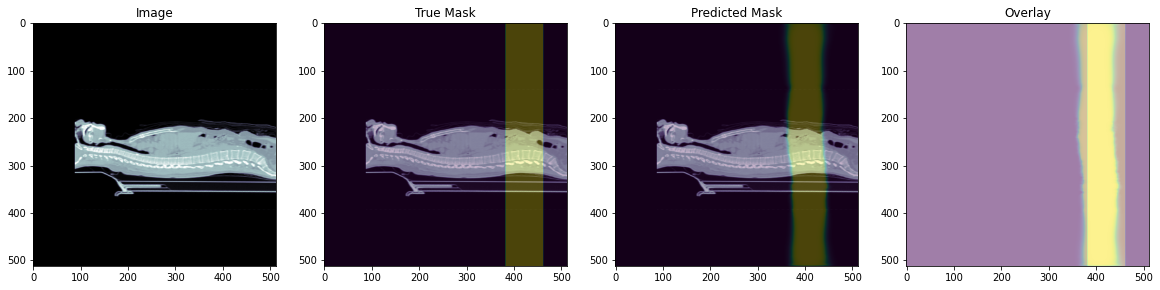


Epoch: 19
valid: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s, dice_bce_loss - 0.07227, dice_score - 0.9255]


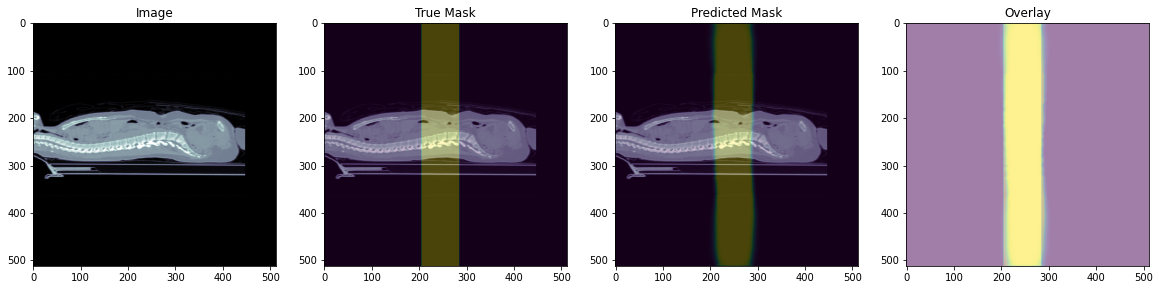


Epoch: 20
valid: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s, dice_bce_loss - 0.08077, dice_score - 0.9118]


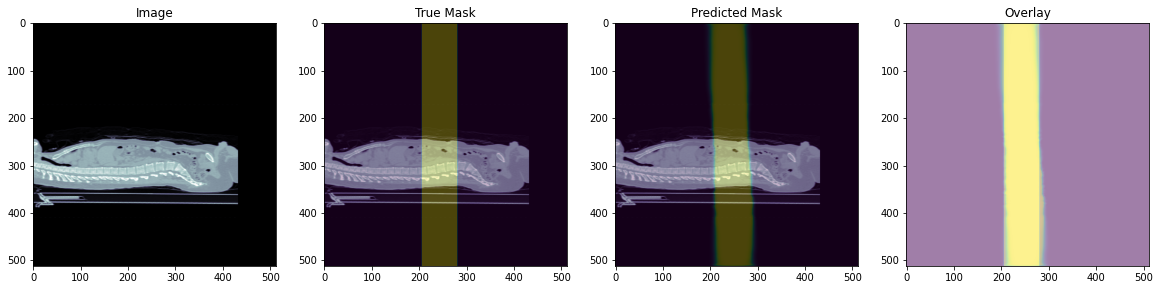


Epoch: 21
valid: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s, dice_bce_loss - 0.07942, dice_score - 0.9173]


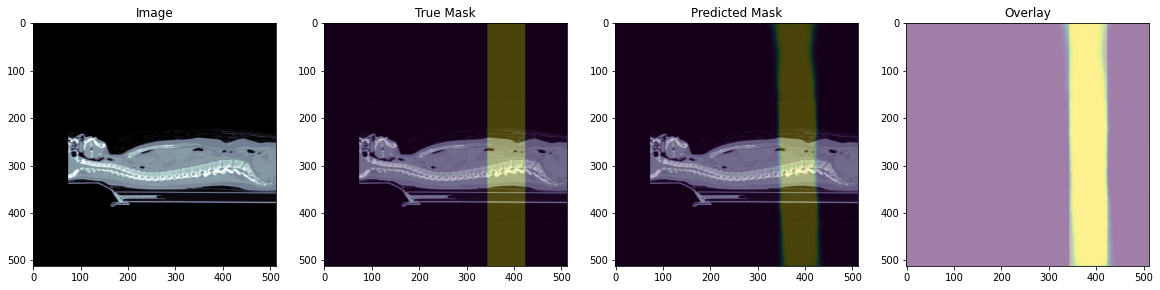


Epoch: 22
valid: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s, dice_bce_loss - 0.06974, dice_score - 0.9287]


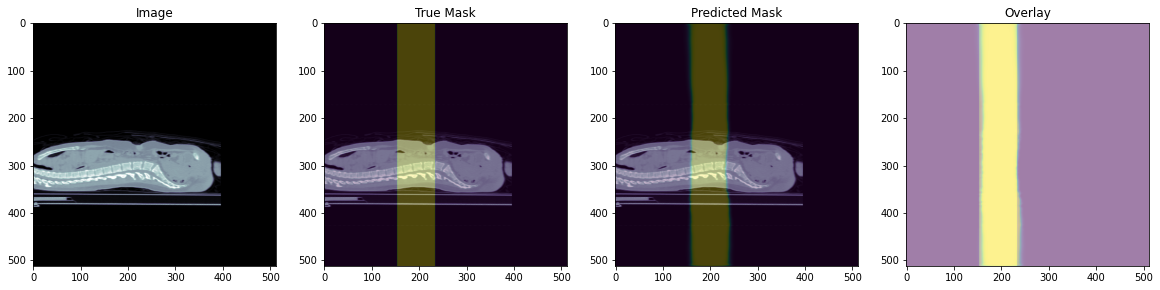


Epoch: 23
valid: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s, dice_bce_loss - 0.06756, dice_score - 0.933] 


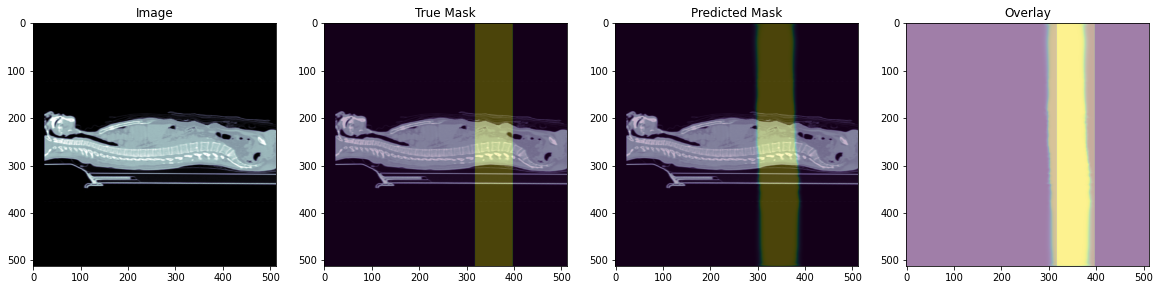


Epoch: 24
valid: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s, dice_bce_loss - 0.06446, dice_score - 0.9349]


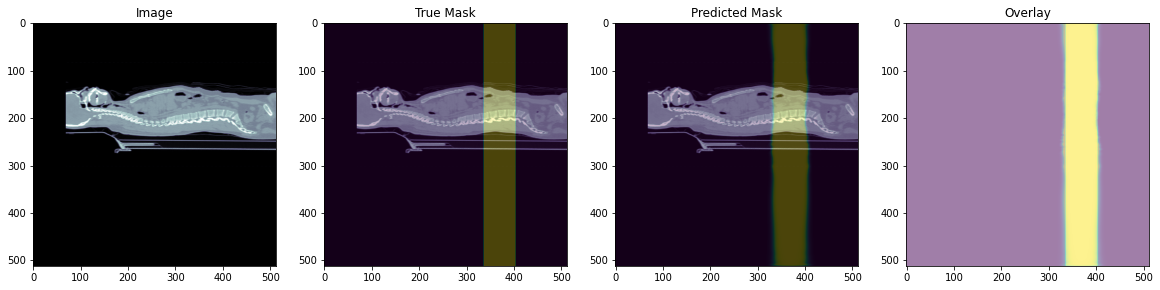


Epoch: 25
valid: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s, dice_bce_loss - 0.06549, dice_score - 0.9314]


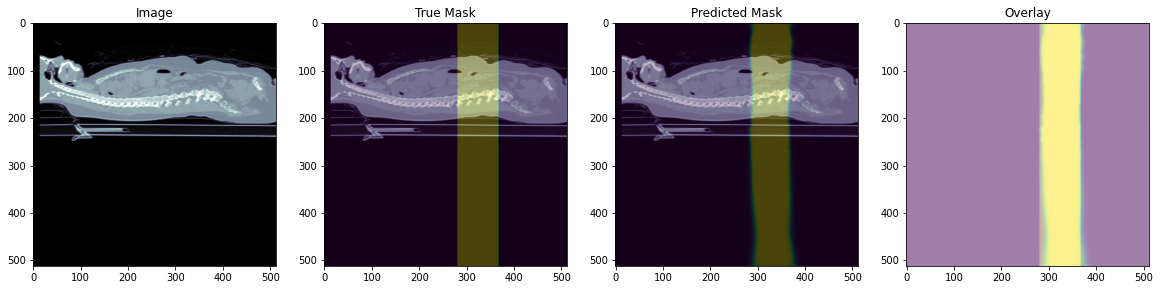


Epoch: 26
valid: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s, dice_bce_loss - 0.06426, dice_score - 0.9331]


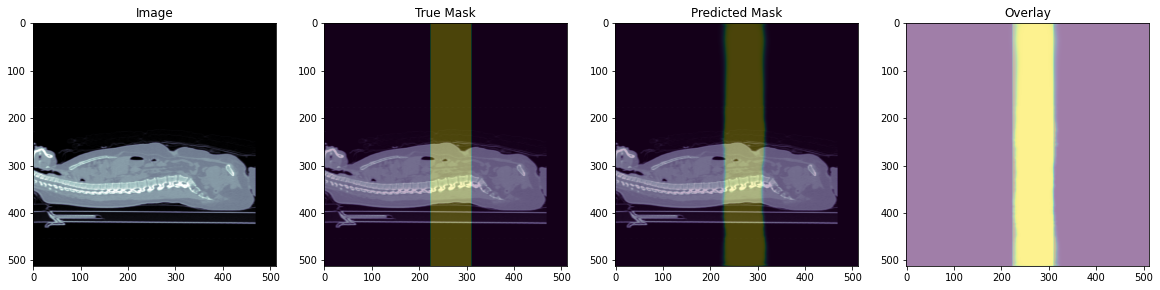


Epoch: 27
valid: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s, dice_bce_loss - 0.06292, dice_score - 0.9359]


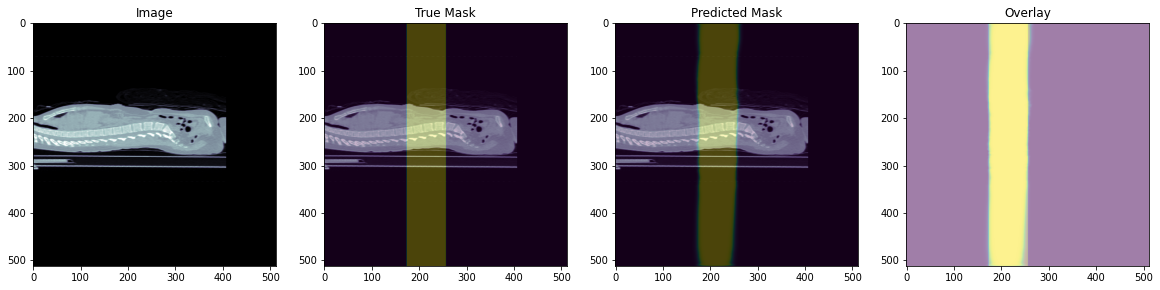


Epoch: 28
valid: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s, dice_bce_loss - 0.06335, dice_score - 0.9357]


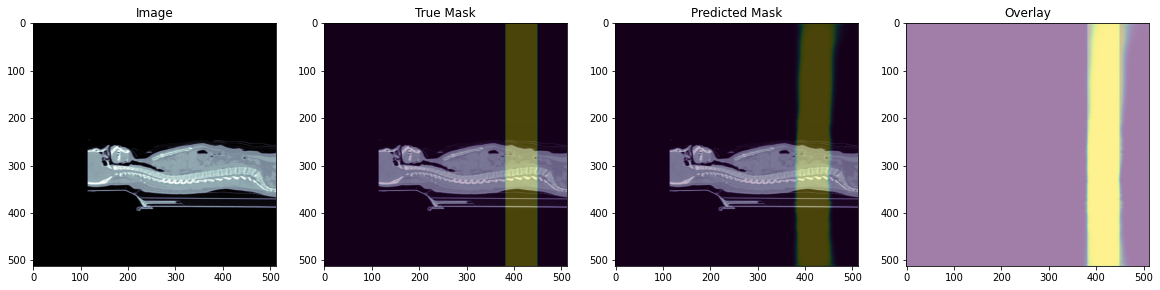


Epoch: 29
valid: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s, dice_bce_loss - 0.06318, dice_score - 0.9359]


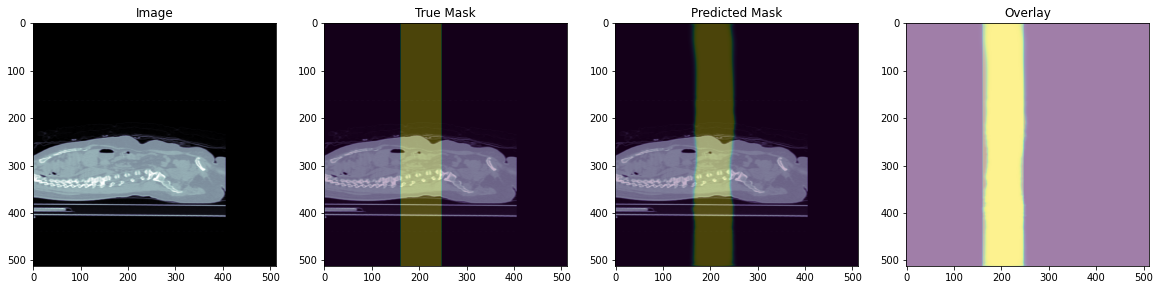

In [10]:
NUM_EPOCH = 30
for i in range(10, NUM_EPOCH):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    path = '../models/unet_effb7/'
    MODEL = 'unet_effb7'
    scheduler.step()
    valid_loss = valid_logs['dice_bce_loss']
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        torch.save(model, f'{path}{fold_index}_{MODEL}_{loss.__name__}_{valid_loss:2.4f}_epoch_{i}.pth')

    with torch.no_grad():
        sample_img, sample_mask = valid_dataset[np.random.randint(valid_dataset.__len__())]
        sample_tensor = torch.cuda.FloatTensor(sample_img[np.newaxis,...])
        sample_pred   = model.predict(sample_tensor).cpu().numpy()[0]

        plt.figure(figsize=(20,5))
        #img, mask = dataset[img_id]
        plt.subplot(1,4,1)
        plt.imshow(sample_img[0,:,:], cmap='bone') # 원본 # permute는 축 변경
        plt.gca().set_title("Image")
        plt.subplot(1,4,2)
        plt.imshow(sample_img[0,:,:], cmap='bone') # 원본 # permute는 축 변경
        plt.imshow(sample_mask[0,:,:], alpha=0.3) # 레이블
        plt.gca().set_title("True Mask")
        plt.subplot(1,4,3)
        plt.imshow(sample_img[0,:,:], cmap='bone') # 원본 # permute는 축 변경
        plt.imshow(sample_pred[0,:,:], alpha=0.3) # 레이블
        plt.gca().set_title("Predicted Mask")
        plt.subplot(1,4,4)
        plt.imshow(sample_mask[0,:,:], alpha=0.3) # 레이블
        plt.imshow(sample_pred[0,:,:], alpha=0.3) # 레이블
        plt.gca().set_title("Overlay")
        plt.show()

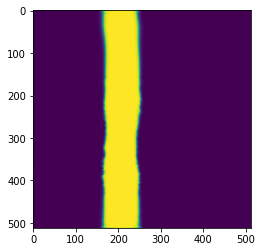

In [13]:
plt.imshow(sample_pred[0,:,:])

array([[0.8400637 , 0.94528717, 0.97591114, ..., 0.9908528 , 0.9618399 ,
        0.8346339 ],
       [0.8459246 , 0.94898695, 0.97800314, ..., 0.99203414, 0.9653967 ,
        0.841694  ],
       [0.85139346, 0.95263636, 0.9798707 , ..., 0.99302906, 0.9684628 ,
        0.84839505],
       ...,
       [0.8323623 , 0.9397463 , 0.97347724, ..., 0.9926553 , 0.9673734 ,
        0.84644365],
       [0.8244305 , 0.9336716 , 0.9702459 , ..., 0.9916113 , 0.9642223 ,
        0.83977896],
       [0.8159725 , 0.9272514 , 0.9664528 , ..., 0.99038094, 0.9605794 ,
        0.8329661 ]], dtype=float32)

In [63]:
print(np.argwhere(col_index).max())
print(np.argwhere(col_index).min())
print(np.median(np.argwhere(col_index)))

201
125
163.0


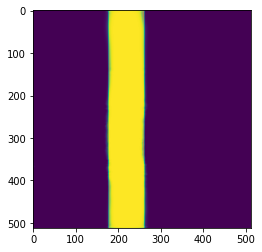

In [76]:
sample_img, sample_mask = valid_dataset[np.random.randint(valid_dataset.__len__())]


sample_tensor = torch.cuda.FloatTensor(sample_img[np.newaxis,...])

sample_pred   = model.predict(sample_tensor).cpu().numpy()[0,0]

col_index = sample_pred[:,:].sum(axis = 0) > sample_pred.shape[1]/2

re_pred = np.zeros(sample_pred.shape)
re_pred[:,col_index] = 1

plt.imshow(re_pred[:,:])
plt.imshow(sample_pred[:,:], alpha = 0.5)

l3_loc = int(np.median(np.argwhere(col_index)))


In [75]:
int(np.median(np.argwhere(col_index)))

219

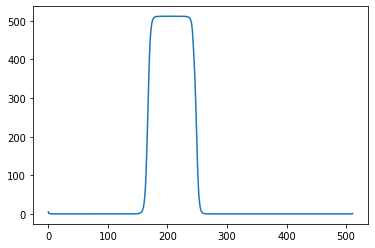

In [35]:
plt.plot(sample_pred[0,:,:].sum(axis = 0))

(array([422.,   3.,   2.,   2.,   2.,   1.,   3.,   2.,   4.,  71.]),
 array([1.44050820e-02, 5.11870193e+01, 1.02359634e+02, 1.53532242e+02,
        2.04704865e+02, 2.55877472e+02, 3.07050079e+02, 3.58222687e+02,
        4.09395325e+02, 4.60567932e+02, 5.11740540e+02], dtype=float32),
 <BarContainer object of 10 artists>)

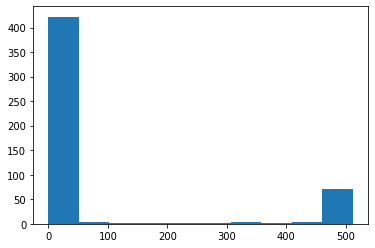

In [18]:
plt.hist(sample_pred[0,:,:].sum(axis = 0))